In [1]:
import pickle
import sys
import os

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.


import matplotlib.pyplot as plt
import numpy as np
import powerlaw as pwl
import scipy
from Functions import plotting, support
from scipy.stats import entropy as sp_entropy

plt.rcParams["text.usetex"] = True
colors = np.array(
    [ 
        [0.3647, 0.2824, 0.1059],
        [0.8549, 0.6314, 0.3294],
        [0.4745, 0.5843, 0.5373],
        [0.4745, 0.3843, 0.7373],
        [107.0 / 255, 42.0 / 255, 2.0 / 255],
    ]
)
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [138]:
d = 2
s = 1
pref = f"d{d}s{s}"

path = f"../Tests/Experiments_simple/{pref}"
with open(path + "/deg_dist.pkl", "rb") as f:
    deg_dist = pickle.load(f)

dim = support.list_dim(deg_dist)
renorms = dim[2]
d = dim[3] 
n_tau = dim[1]
rep = dim[0]

In [139]:
def KS(deg1,deg2):
    test = scipy.stats.kstest(deg1, deg2)
    return test.statistic 

def mean_degree(deg1,deg2):
    return np.mean(deg2)

def var_degree_difference(deg1,deg2):
    return abs(np.var(deg2) - np.var(deg1))

def mean_degree_difference(deg1,deg2):
    return abs(np.mean(deg2) - np.mean(deg1))

def JS(deg1,deg2):
    dmax = int(max(np.max(deg1),np.max(deg2)))
    p1 = np.zeros(dmax+1)
    p2 = np.zeros(dmax+1)
    for i in deg1:
        p1[int(i)] += 1
    for i in deg2:
        p2[int(i)] += 1
    p1 = p1/np.sum(p1)
    p2 = p2/np.sum(p2)
    p12 = 0.5 * (p1 + p2)
    jsd = 0.5 * (sp_entropy(p1, p12, base=2) + sp_entropy(p2, p12, base=2))
    return jsd

In [140]:

measure = JS

Ns = np.zeros((rep, renorms, n_tau), dtype=int)
for r in range(rep):
    for i in range(renorms):
        for t in range(n_tau):
            Ns[r, i, t] = len(deg_dist[r][t][i][0])

deg_distance = np.zeros((rep, d+1, d, n_tau))
for r in range(rep):
    for norml in range(d+1):
        for degg in range(d):
            deg1 = deg_dist[r][0][norml][degg]
            for tau in range(n_tau):
                deg2 = deg_dist[r][tau][norml][degg]
                if len(deg2) == 0:
                    deg2 = [0]
                deg_distance[r, norml, degg, tau] = measure(deg1,deg2)

N = Ns[0,0,0]


686.5
392.8
196.9


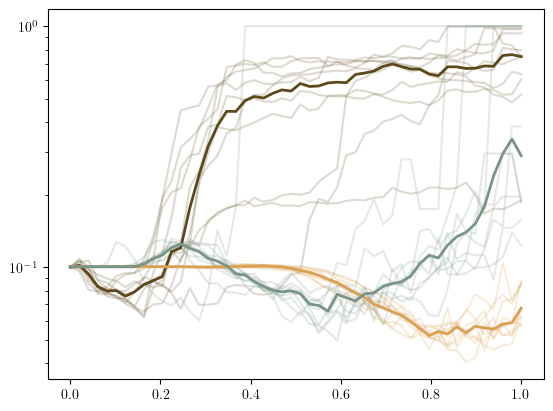

In [150]:
lam  = 0.1
for norml in range(d+1):
    for r in range(rep):
        plt.semilogy(np.linspace(0,1,n_tau),deg_distance[r,norml,0,:] + lam*Ns[r,norml,:]/N,color = colors[norml,:],alpha = 0.2)
for norml in range(d+1):
    plt.semilogy(np.linspace(0,1,n_tau), np.median(deg_distance[:,norml,0,:] + lam*Ns[:,norml,:]/N,0), color = colors[norml,:], lw = 2)

for norml in range(d+1):
    print(np.mean(Ns[:,norml,int(np.floor(np.argmin(np.median(deg_distance[:,norml,0,:] + lam*Ns[:,norml,:]/N,0))))]))


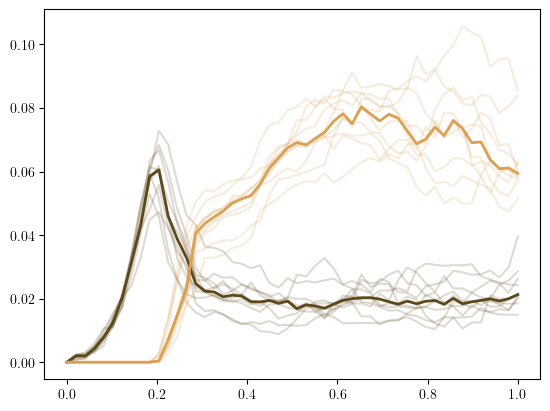

In [125]:
for norml in range(d+1):
    for r in range(rep):
        plt.plot(np.linspace(0,1,n_tau),deg_distance[r,norml,0,:],color = colors[norml,:],alpha = 0.2)
for norml in range(d+1):
    plt.plot(np.linspace(0,1,n_tau), np.median(deg_distance[:,norml,0,:],0), color = colors[norml,:], lw = 2)



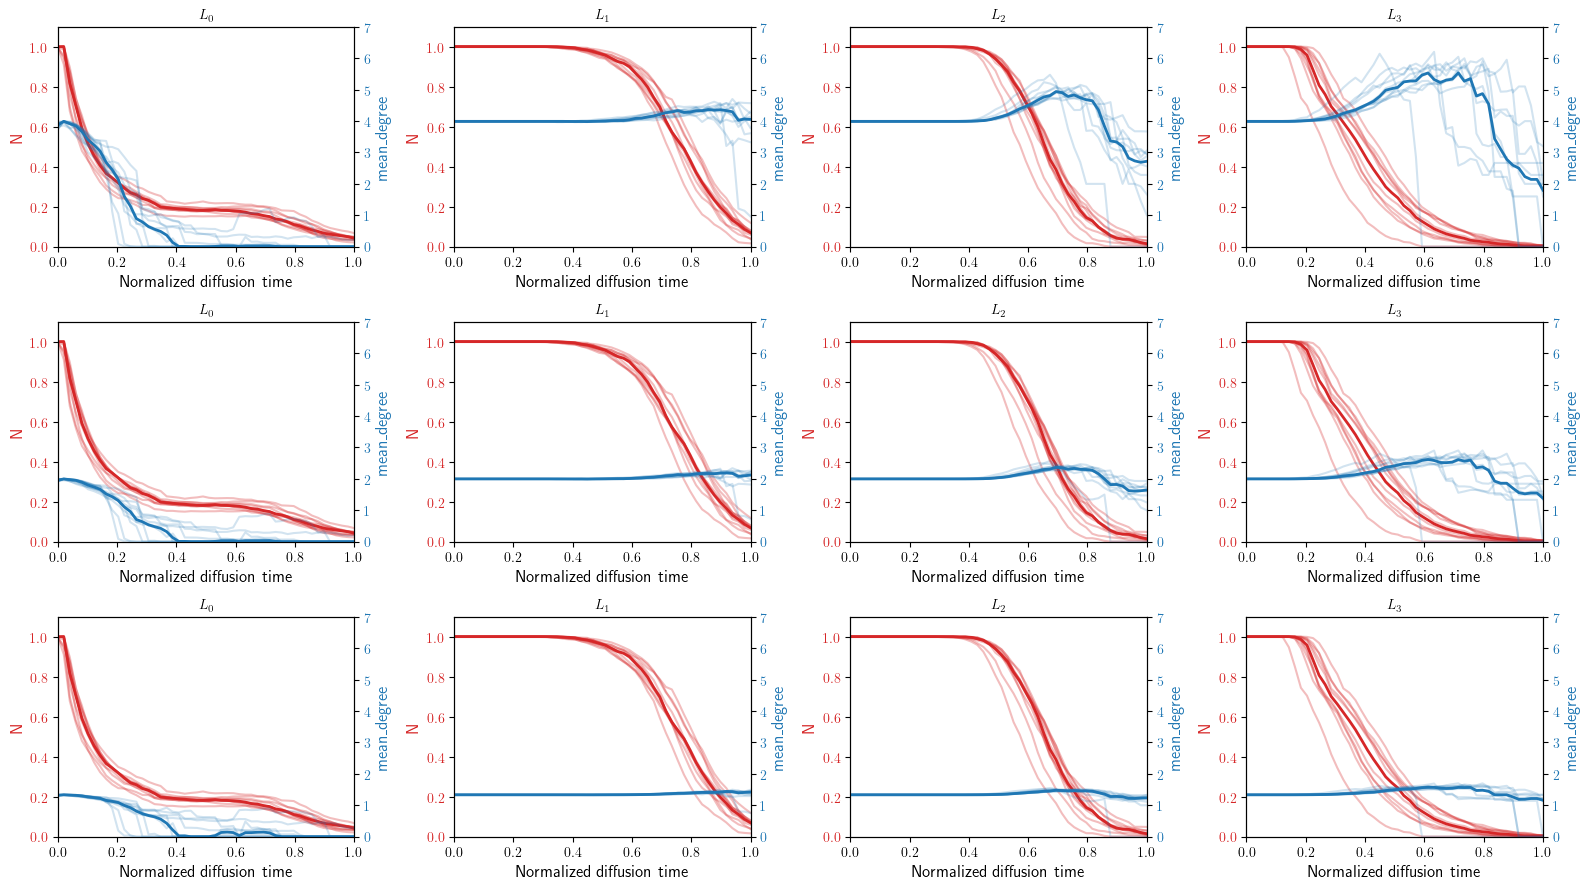

In [25]:
fig, axv = plt.subplots(d,d+1,figsize = (4*(d+1),3*d))

for degg in range(d):
    for norml in range(d+1):
        color = 'tab:red'
        if d == 1:
            ax1 = axv[norml]
        else:
            ax1 = axv[degg,norml]
        ax1.set_title("$L_"+str(norml)+"$")
        ax1.set_xlabel('Normalized diffusion time')
        ax1.set_ylabel('N', color=color)
        for r in range(rep):
            ax1.plot(np.linspace(0,1,n_tau), Ns[r,norml,:]/N, color=color, alpha = 0.3)

        ax1.plot(np.linspace(0,1,n_tau), np.median(Ns[:,norml,:]/N,0), color = color, lw = 2)

        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim(0,1)
        ax1.set_ylim(bottom = 0, top = 1.1)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel(measure.__name__, color=color)  # we already handled the x-label with ax1
        for r in range(rep):
            ax2.plot(np.linspace(0,1,n_tau), deg_distance[r,norml,degg,:], color=color, alpha = 0.2)
        ax2.plot(np.linspace(0,1,n_tau), np.median(deg_distance[:,norml,degg,:],0), color = color, lw = 2)

        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yscale('symlog',linthresh=0.01)
        ax2.set_ylim(bottom = 0, top = 1.1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(path + f"/deg_errors_{measure.__name__}.pdf", format="pdf")  # , bbox_inches="tight")


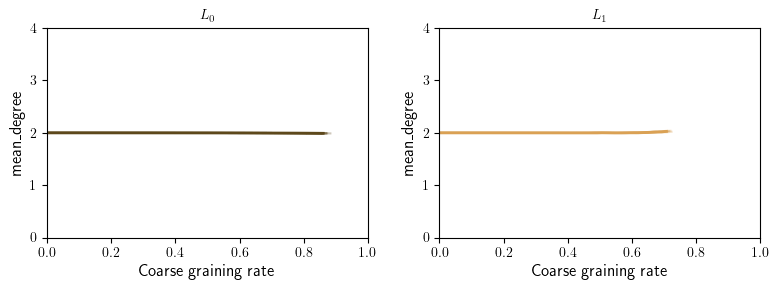

In [8]:
fig, axv = plt.subplots(d,d+1,figsize = (4*(d+1),3*d))

for degg in range(d):
    for norml in range(d+1):
        if d == 1:
             ax1 = axv[norml]
        else:
            ax1 = axv[degg,norml]
        ax1.set_title("$L_"+str(norml)+"$")
        ax1.set_xlabel('Coarse graining rate')
        ax1.set_ylabel(measure.__name__)
        for r in range(rep):
                ax1.plot(1-Ns[r,norml,:]/N, deg_distance[r,norml,degg,:], color=colors[norml,:], alpha = 0.3)

        ax1.plot(1-np.median(Ns[:,norml,:]/N,0), np.median(deg_distance[:,norml,degg,:],0), color = colors[norml,:], lw = 2)

        ax1.set_ylim(bottom = 0, top = 1.1)
        ax1.set_yscale('symlog',linthresh=0.01)
        ax1.set_xlim(0,1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(path + f"/coarse_graining_rate_{measure.__name__}.pdf", format="pdf")  # , bbox_inches="tight")


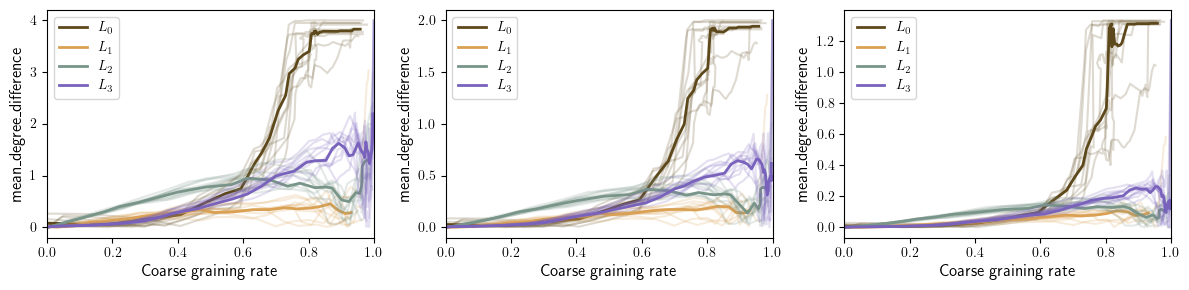

In [19]:
fig, axv = plt.subplots(1,d,figsize = (4*d,3))

for degg in range(d):
    if d == 1:
        ax1 = axv
    else:
        ax1 = axv[degg]
    #ax1.set_title("$L_"+str(norml)+"$")
    ax1.set_xlabel('Coarse graining rate')
    ax1.set_ylabel(measure.__name__)
    #ax1.set_ylim(bottom = 0, top = 1)
    ax1.set_xlim(0,1)
    #ax1.set_yscale('symlog',linthresh=0.01)
    for norml in range(d+1):
        for r in range(rep):
                ax1.plot(1-Ns[r,norml,:]/N, deg_distance[r,norml,degg,:], color=colors[norml,:], alpha = 0.2)
        ax1.plot(1-np.median(Ns[:,norml,:]/N,0), np.median(deg_distance[:,norml,degg,:],0), color = colors[norml,:], lw = 2,label = f"$L_{norml}$")
    ax1.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(path + f"/coarse_graining_rate_together_{measure.__name__}.pdf", format="pdf")  # , bbox_inches="tight")